# Transactions - Data Modelling

In [1]:
import os

import joblib
import numpy as np
import pandas as pd
import skops.io as sio
from tqdm import tqdm
import warnings

import helpers
from helpers import (
    CHARTS_DIR, ENCODER_MODEL_DIR, RAW_DATA_DIR, TRANSFORMED_DATA_DIR
)

## Load integrated data

In [2]:
df_transactions = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt7_integrated.parquet')
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,median_income,mean_income,n_households,wellbeing_index,money_supply_millions,unemployment_rate,population_thousands,n_crimes,date,interest_rate
34996,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,128.0,129888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34997,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1007.0,1007.0,122.0,122888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34998,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,122.0,123888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
34999,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,2.000000,753.0,672.0,120.0,90000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
35000,BUKIT BANDARAYA,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,1.0,3.078282,1875.0,1126.0,180.0,338000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5


In [3]:
df_transactions.columns

Index(['township', 'building_type', 'tenure', 'floors', 'rooms', 'land_area',
       'built_up', 'price_psf', 'price', 'year', 'month', 'day', 'cpi',
       'median_income', 'mean_income', 'n_households', 'wellbeing_index',
       'money_supply_millions', 'unemployment_rate', 'population_thousands',
       'n_crimes', 'date', 'interest_rate'],
      dtype='object')

## Check for feature correlation and association

Before we begin modelling, we need to check for feature correlation and association. However, we need to determine the scale of the features first:

**Continuous data:**
1. Interval:
    - cpi
2. Ratio:
    - land_area
    - built_up
    - median_income
    - mean_income
    - wellbeing_index
    - money_supply_millions
    - unemployment_rate
    - interest_rate
    - price_psf

**Discrete data:**
1. Nominal:
    - township
    - building_type
    - tenure
2. Ordinal:
    - year
    - month
    - day
3. Ratio:
    - n_households
    - population_thousands
    - n_crimes
    - floors
    - rooms

Before selecting the appropriate correlation and association tests, we need to determine the normality of the continuous data. We will use the Shapiro-Wilk test for normality, which is provided by Scipy's `normaltest`.

In [4]:
from scipy.stats import kruskal, normaltest, pearsonr, spearmanr

In [5]:
continuous_vars = [
    'land_area',
    'built_up',
    'price_psf',
    'median_income',
    'mean_income',
    'wellbeing_index',
    'money_supply_millions',
    'unemployment_rate',
    'interest_rate'
]

for var in continuous_vars:
    normal_result = normaltest(df_transactions[var], nan_policy='omit')
    print(f"Normality test for {var}: {normal_result}")

Normality test for land_area: NormaltestResult(statistic=590870.0868928022, pvalue=0.0)
Normality test for built_up: NormaltestResult(statistic=265651.55731307523, pvalue=0.0)
Normality test for price_psf: NormaltestResult(statistic=175457.22731882718, pvalue=0.0)
Normality test for median_income: NormaltestResult(statistic=21166671.14165013, pvalue=0.0)
Normality test for mean_income: NormaltestResult(statistic=1423955.698392976, pvalue=0.0)
Normality test for wellbeing_index: NormaltestResult(statistic=58074.19249076957, pvalue=0.0)
Normality test for money_supply_millions: NormaltestResult(statistic=62418.155795693216, pvalue=0.0)
Normality test for unemployment_rate: NormaltestResult(statistic=72219.24276097854, pvalue=0.0)
Normality test for interest_rate: NormaltestResult(statistic=28612.33706469147, pvalue=0.0)


All of the continuous variables are not from normal distribution.

### Selecting the appropriate correlation and association tests

Our target variable for modelling is `price_psf`. We will check for correlation and association between `price_psf` and the other features. Let's choose the appropriate correlation and association tests for the different types of data:

**Continuous data vs price_psf:** 
1. Interval: Pearson's correlation coefficient
2. Ratio: Pearson's correlation coefficient

**Discrete data vs price_psf:**
1. Nominal: Kruskal-Wallis H-test
2. Ordinal: Spearman's rank correlation coefficient
3. Ratio: Pearson's correlation coefficient

### Continuous variables (interval and ratio) vs `price_psf`

In [6]:
target_var = 'price_psf'

for var in continuous_vars:
    pearson_result = pearsonr(df_transactions[var], df_transactions[target_var])
    print(f"Pearson correlation test for {var}: {pearson_result}")

Pearson correlation test for land_area: PearsonRResult(statistic=-0.0003414081028704389, pvalue=0.8698648254733987)
Pearson correlation test for built_up: PearsonRResult(statistic=0.27575433819443673, pvalue=0.0)
Pearson correlation test for price_psf: PearsonRResult(statistic=0.9999999999999937, pvalue=0.0)
Pearson correlation test for median_income: PearsonRResult(statistic=0.46978636197555945, pvalue=0.0)
Pearson correlation test for mean_income: PearsonRResult(statistic=0.47441434743219024, pvalue=0.0)
Pearson correlation test for wellbeing_index: PearsonRResult(statistic=0.4682907609353156, pvalue=0.0)
Pearson correlation test for money_supply_millions: PearsonRResult(statistic=0.4708744423231275, pvalue=0.0)
Pearson correlation test for unemployment_rate: PearsonRResult(statistic=0.054053978128958124, pvalue=1.4904119594671785e-148)
Pearson correlation test for interest_rate: PearsonRResult(statistic=-0.26080401092289723, pvalue=0.0)


For Pearson test (DV: continuous, IV: continuous), the null hypothesis H0 is that the two samples are uncorrelated.

Having p-values < 0.05 means that `built_up`, `median_income`, `mean_income`, `wellbeing_index`, `money_supply_millions`, `unemployment_rate` and `interest_rate` are correlated with `price_psf`.

Surprisingly, `land_area` is not correlated with `price_psf` as the p-value is > 0.05, thus we were unable to reject the null hypothesis. `land_area` is uncorrelated with `price_psf`. Let's check with plot.

<Axes: title={'center': 'Land Area vs Price per Square Feet'}, xlabel='land_area', ylabel='price_psf'>

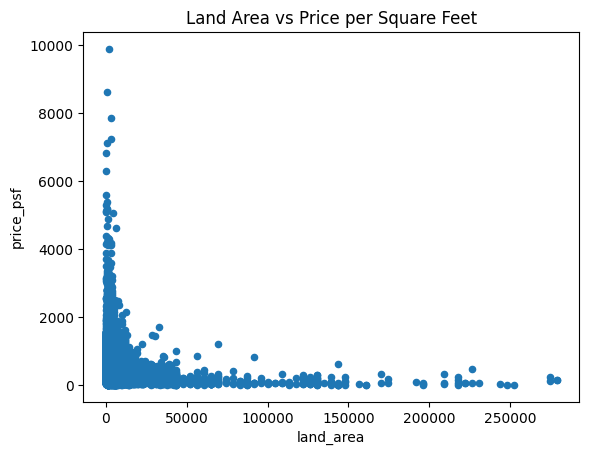

In [7]:
df_transactions[['price_psf', 'land_area']].plot(
    kind='scatter',
    x='land_area',
    y='price_psf',
    title='Land Area vs Price per Square Feet'
)

Based on the plot above, we can see that there is no correlation between `land_area` and `price_psf`.

### Discrete variables (nominal) vs `price_psf`

In [8]:
nominal_vars = ['township', 'building_type', 'tenure']

for var in nominal_vars:
    kruskal_result = kruskal(*df_transactions[[var, target_var]].groupby(var, observed=True)[target_var].apply(list), nan_policy='omit')
    print(f"Kruskal-Wallis result for {var} and {target_var}: {kruskal_result}")

Kruskal-Wallis result for township and price_psf: KruskalResult(statistic=143840.41840357677, pvalue=0.0)
Kruskal-Wallis result for building_type and price_psf: KruskalResult(statistic=71844.01611948658, pvalue=0.0)
Kruskal-Wallis result for tenure and price_psf: KruskalResult(statistic=17776.816993317563, pvalue=0.0)


For Kruskal-Wallis test (DV: continuous, IV: nominal), the null hypothesis H0 is that the population median of all of the groups are equal (thus no association as different groups has the similar population median), while the alternative hypothesis H1 is that the population median of all of the groups are not equal (thus has association as different groups will have different population median).

Since the computed p-values < 0.05 therefore we reject the null hypothesis H0 and conclude that there is association between the nominal variables `township`, `building_type` and `tenure` against `price_psf`.

### Discrete variables (ordinal) vs `price_psf`

In [9]:
ordinal_vars = ['year', 'month', 'day']

for var in ordinal_vars:
    spearman_result = spearmanr(df_transactions[var], df_transactions[target_var], nan_policy='omit')
    print(f"Spearman result for {var} and {target_var}: {spearman_result}")

Spearman result for year and price_psf: SignificanceResult(statistic=0.5955678854090415, pvalue=0.0)
Spearman result for month and price_psf: SignificanceResult(statistic=0.05417040095458992, pvalue=3.471348050926613e-149)
Spearman result for day and price_psf: SignificanceResult(statistic=0.006744450409726356, pvalue=0.0012101790242186501)


For Spearman rank test (DV: continuous, IV: ordinal), the null hypothesis H0 is that there is no correlation between variables, while the alternative hypothesis H1 is that there is a correlation between variables.

Since the computed p-values are close to 0.0 (less than 0.05) therefore we reject the null hypothesis H0 and conclude that there is a correlation between variables. Thus, `year`, `month` and `day` has an impact on the `price_psf`.

### Discrete variables (ratio) vs `price_psf`

In [10]:
ratio_vars = ['n_households', 'population_thousands', 'n_crimes', 'floors', 'rooms']

for var in ratio_vars:
    pearson_result = pearsonr(df_transactions[var], df_transactions[target_var])
    print(f"Pearson correlation test for {var}: {pearson_result}")

Pearson correlation test for n_households: PearsonRResult(statistic=0.4585270925268039, pvalue=0.0)
Pearson correlation test for population_thousands: PearsonRResult(statistic=0.44512550413939594, pvalue=0.0)
Pearson correlation test for n_crimes: PearsonRResult(statistic=-0.46551192428577126, pvalue=0.0)
Pearson correlation test for floors: PearsonRResult(statistic=0.0797170397562012, pvalue=3.51e-321)
Pearson correlation test for rooms: PearsonRResult(statistic=0.05268622045361267, pvalue=3.202016933693272e-141)


However, the Spearman rank test (DV: continuous, IV: ratio) shows otherwise. Similarly, the null hypothesis H0 is that there is no correlation between variables, while the alternative hypothesis H1 is that there is a correlation between variables.

Since the computed p-values are close to 0.0 (less than 0.05) therefore we reject the null hypothesis H0 and conclude that there is a correlation between the ratio variables `n_households`, `population_thousands`, `n_crimes`, `floors`, `rooms` on `price_psf`.

## Data splitting

In [11]:
df_transactions = df_transactions.sort_values(by=['date'])
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,median_income,mean_income,n_households,wellbeing_index,money_supply_millions,unemployment_rate,population_thousands,n_crimes,date,interest_rate
34996,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,128.0,129888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34997,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1007.0,1007.0,122.0,122888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34998,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,122.0,123888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
34999,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,2.000000,753.0,672.0,120.0,90000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
35000,BUKIT BANDARAYA,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,1.0,3.078282,1875.0,1126.0,180.0,338000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5


In [12]:
df_train = df_transactions.query('year <= 2020')
df_train['year'].value_counts().sort_index()


year
2000.0     6470
2001.0     6494
2002.0     7547
2003.0     8379
2004.0    10449
2005.0     9382
2006.0     8990
2007.0    11603
2008.0    11943
2009.0    13817
2010.0    13409
2011.0    14156
2012.0    12561
2013.0    14271
2014.0    12335
2015.0     9877
2016.0     8573
2017.0     9371
2018.0     8758
2019.0     7388
2020.0     6775
Name: count, dtype: int64

In [13]:
df_test = df_transactions.query('year >= 2021')
df_test['year'].value_counts().sort_index()

year
2021.0    7492
2022.0    8136
2023.0    2098
Name: count, dtype: int64

## Pre-modelling visualisation

Raw data contains 200k data, across 24 years (2000 - 2023). This means that there will be multiple data points for each date (timestamp). In order for traditional time series modelling to work, we need to aggregate the data. In this case, we try to aggregate the data by year, month and day.

In [14]:
df_yearly_price_psf_train = df_train[['year', 'price_psf']]
df_monthly_price_psf_train = df_train[['year', 'month', 'price_psf']]
df_daily_price_psf_train = df_train[['date', 'price_psf']]

### Aggregating data by year

<Axes: title={'center': 'Mean and Median Price per Square Feet per Year'}, xlabel='year'>

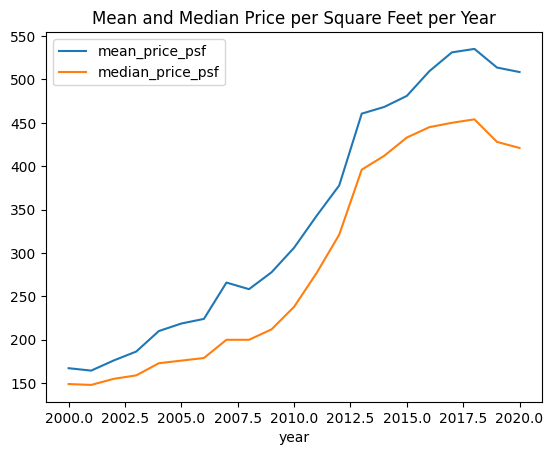

In [15]:
mean_yearly_price_psf = df_yearly_price_psf_train.groupby('year').mean()
median_yearly_price_psf = df_yearly_price_psf_train.groupby('year').median()

df_price_psf_per_year = pd.concat([mean_yearly_price_psf, median_yearly_price_psf], axis=1)
df_price_psf_per_year.columns = ['mean_price_psf', 'median_price_psf']

df_price_psf_per_year.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Year',
)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

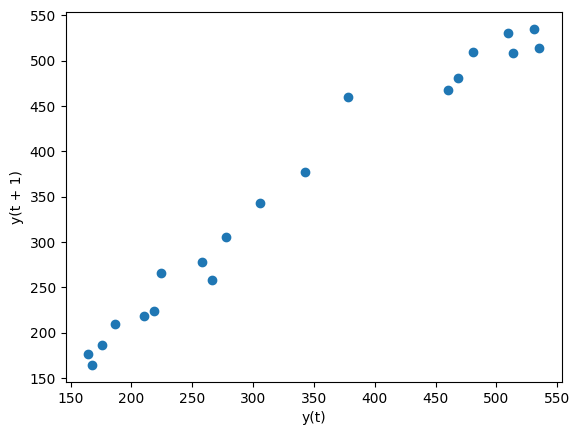

In [16]:
from pandas.plotting import autocorrelation_plot, lag_plot

lag_plot(mean_yearly_price_psf['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

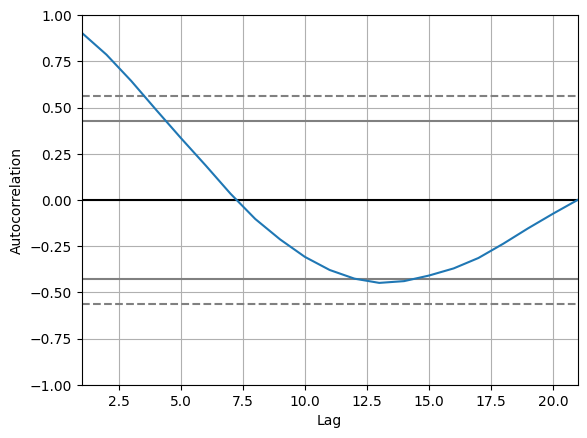

In [17]:
autocorrelation_plot(mean_yearly_price_psf['price_psf'])

Although the aggregated data has a reasonable time plot, there were only 21 data points. This is not enough for time series modelling. Further granulatity is required.

### Aggregating data by month

In [18]:
df_monthly_price_psf_train['year_month'] = pd.to_datetime(df_monthly_price_psf_train[['year', 'month']].assign(day=1)) 
df_monthly_price_psf_train.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_10224\447924927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_price_psf_train['year_month'] = pd.to_datetime(df_monthly_price_psf_train[['year', 'month']].assign(day=1))


,year,month,price_psf,year_month
34996,2000.0,1.0,128.0,2000-01-01
34997,2000.0,1.0,122.0,2000-01-01
34998,2000.0,1.0,122.0,2000-01-01
34999,2000.0,1.0,120.0,2000-01-01
35000,2000.0,1.0,180.0,2000-01-01


Number of months from 2000 to 2020: 252
Length of grouped dataframe: 252


<Axes: title={'center': 'Mean and Median Price per Square Feet per Month'}, xlabel='year_month'>

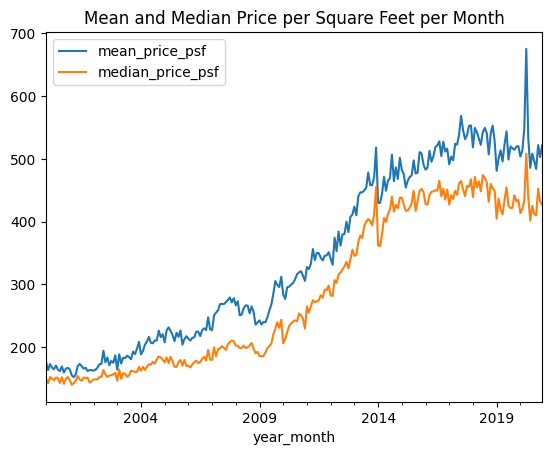

In [19]:
mean_monthly_price_psf = df_monthly_price_psf_train[['year_month', 'price_psf']].groupby('year_month').mean()
median_monthly_price_psf = df_monthly_price_psf_train[['year_month', 'price_psf']].groupby('year_month').median()

df_price_psf_per_month = pd.concat([mean_monthly_price_psf, median_monthly_price_psf], axis=1)
df_price_psf_per_month.columns = ['mean_price_psf', 'median_price_psf']

print(f'Number of months from 2000 to 2020: {12 * 21}')
print(f'Length of grouped dataframe: {len(df_price_psf_per_month)}')

df_price_psf_per_month.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month',
)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

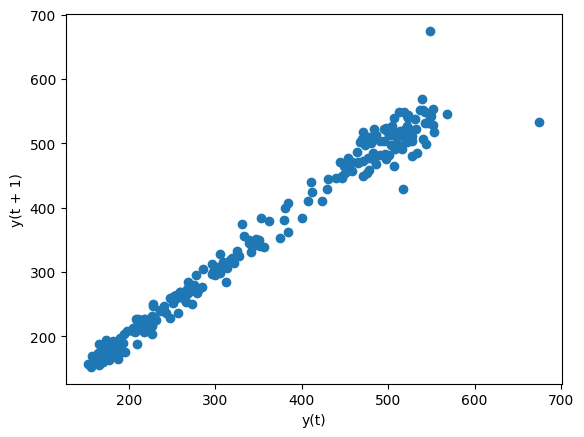

In [20]:
lag_plot(mean_monthly_price_psf['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

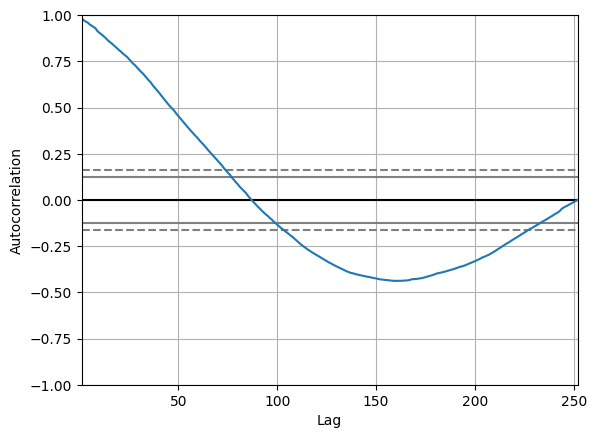

In [21]:
autocorrelation_plot(mean_monthly_price_psf['price_psf'])

By aggregating the data by month, we have 252 data points. This is a reasonable amount of data points for time series modelling. However, let's try to aggregate the data by day and see if this is a better option.

Moreover, the lag plot shows that there is a strong correlation between the current month's `price_psf` and the previous month's `price_psf`. This is a good sign for time series modelling.

### Aggregating data by date

Number of days from 2000 to 2020: 7665
Length of grouped dataframe: 7093


<Axes: title={'center': 'Mean and Median Price per Square Feet per Day'}, xlabel='date'>

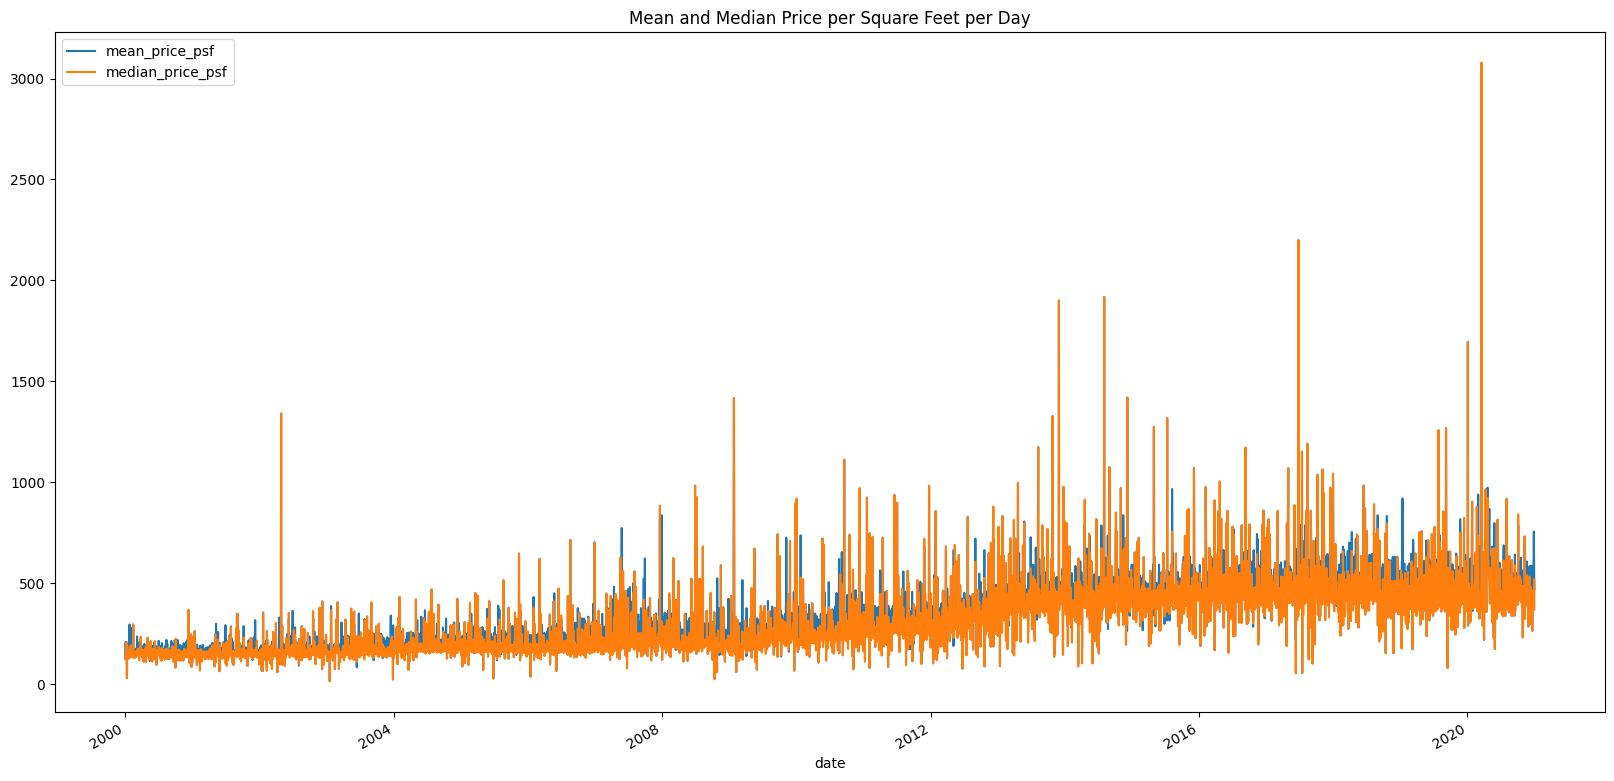

In [22]:
mean_daily_price_psf = df_daily_price_psf_train.groupby('date').mean()
median_daily_price_psf = df_daily_price_psf_train.groupby('date').median()

df_price_psf_per_day = pd.concat([mean_daily_price_psf, median_daily_price_psf], axis=1)
df_price_psf_per_day.columns = ['mean_price_psf', 'median_price_psf']

print(f'Number of days from 2000 to 2020: {365 * 21}')
print(f'Length of grouped dataframe: {len(df_price_psf_per_day)}')

df_price_psf_per_day.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Day',
    figsize=(20, 10)
)

There should be a minimum of 7665 transactions (one transaction per day) but we only have 7093 transactions. This means that there are days with no transactions.

Additionally, based on the chart above, there are more than one transaction per day.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

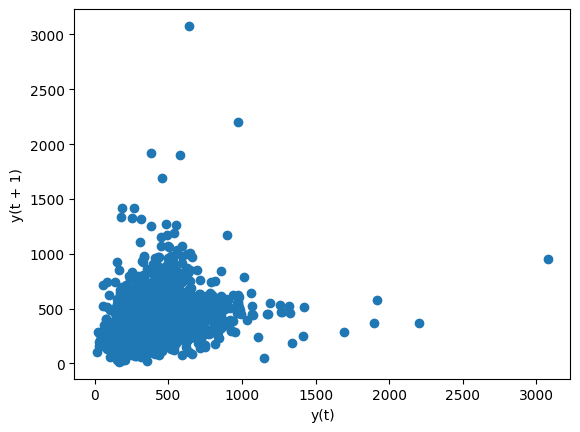

In [23]:
lag_plot(mean_daily_price_psf['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

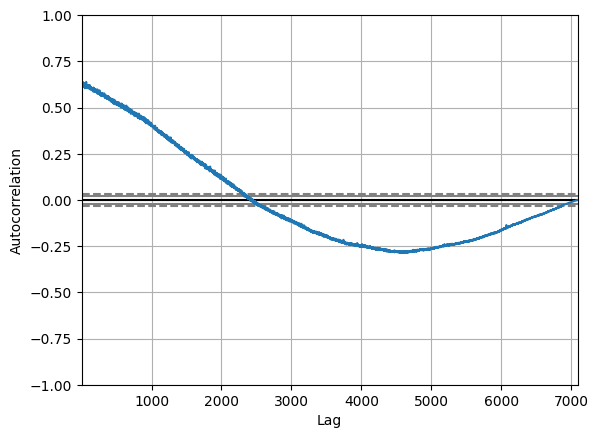

In [24]:
autocorrelation_plot(mean_daily_price_psf['price_psf'])

Although aggregating the data by day gives us the most granular data, the lag plot is fairly dispersed and there is no clear correlation between the current day's `price_psf` and the previous day's `price_psf`. This is not a good sign for time series modelling.

Moving forward, we will use monthly data for forecasting.

## Time series modelling

From the literature, the most popular methods are:
- Time series methods:
    1. ARIMA (Abidoye et al., 2019; Dejniak & Dąbrowski, 2017; Iliychovski et al., 2022; Y. Li et al., 2020; Liu & Wu, 2020; Samadani & Costa, 2021)
    2. SARIMA (Samadani & Costa, 2021)
    3. Holt’s exponential smoothing (Liu & Wu, 2020)
- Machine learning approaches :
    1. random forest regression (Ayyasamy et al., 2022)
    2. support vector regression (Ayyasamy et al., 2022; D.-Y. Li et al., 2009; Y. Li et al., 2020; Plakandaras et al., 2015)
    3. neural networks (Abidoye et al., 2019; Kang et al., 2020; Liu & Wu, 2020; Sa’at et al., 2021; Samadani & Costa, 2021; Xu & Zhang, 2021)

These techniques will be implemented in this study as they were not completely compared against each other in the prior studies.

As this is a time series study, traditional cross validation approach is unsuitable due to time dependencies. Bergmeir & Benítez (2012) suggested the use of blocked cross validation, where the time series data is divided into consecutive segments with fixed number of data points. In each segment, the data is divided into training and validation set. In this way, each data point is fully utilised.

Let's check the normality, autocorrelation and partial autocorrelation of the time series.

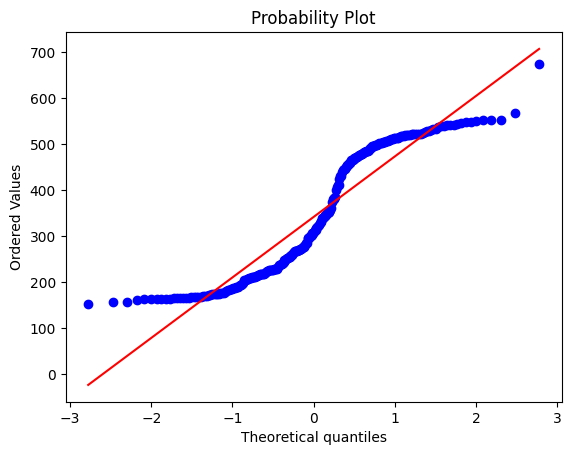

In [25]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

probplot(mean_monthly_price_psf['price_psf'], plot=plt)
plt.show()

The time series is not normally distributed. This is expected for time series.

Let's check if the data is stationary.

In [26]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)

In [27]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(mean_monthly_price_psf['price_psf'])
print_adf_result(adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.717107
P-Value                   0.842268
# Lags Used              15.000000
# Observations Used     236.000000
Critical Value (1%)      -3.458366
Critical Value (5%)      -2.873866
Critical Value (10%)     -2.573339
dtype: float64


The Augmented Dickey-Fuller (ADF) test is to test for stationarity. The null hypothesis H0 is that the time series is non-stationary, while the alternative hypothesis H1 is that the time series is stationary.

Since the computed p-value is more than 0.05, we fail to reject the null hypothesis H0 and conclude that the time series is non-stationary. We need to perform differencing to achieve stationarity. We can use the STL method to perform differencing (detrending and deseasonalising).

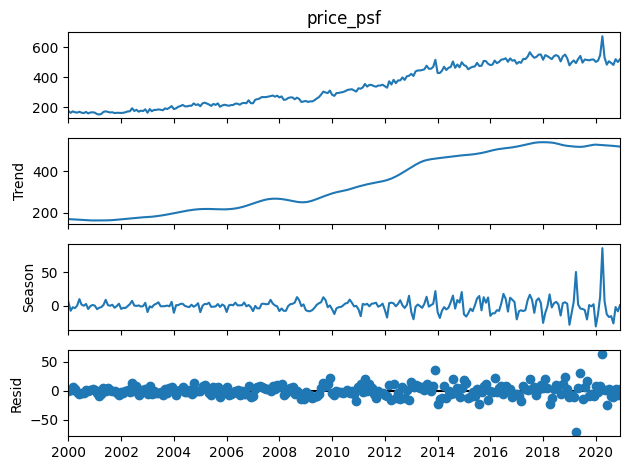

In [28]:
from statsmodels.tsa.seasonal import STL

mean_price_psf_stl = STL(mean_monthly_price_psf['price_psf'], period=12).fit()
mean_price_psf_stl.plot()
plt.show()

Based on STL decomposition, there are increasing trend and seasonality:
1. The trend is flat until 2004, where it started to increase steadily until 2018. Then it plateaued until 2020.
2. The seasonality is flat until 2008, where it started to increase slightly at 2012. Seasonality spiked at 2019 onwards.
3. No pattern is spotted for residuals. However, there could be some noise at 2014, 2019 and 2020.

Let's perform differencing using `period=12` (12 months) and check if the differenced time series is stationary.

In [29]:
mean_monthly_price_psf_diff = mean_monthly_price_psf['price_psf'].diff(12).dropna()
adf_result = adfuller(mean_monthly_price_psf_diff)
print_adf_result(adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.519076
P-Value                   0.007510
# Lags Used              12.000000
# Observations Used     227.000000
Critical Value (1%)      -3.459490
Critical Value (5%)      -2.874358
Critical Value (10%)     -2.573602
dtype: float64


The p-value of ADF test is less than 0.05, therefore we reject the null hypothesis H0 and conclude that the differenced time series is stationary.

Let's check the autocorrelation and partial autocorrelation of the original and differenced time series.

<Axes: title={'center': 'Mean Price per Square Feet per Month (Differenced with period=12)'}, xlabel='year_month'>

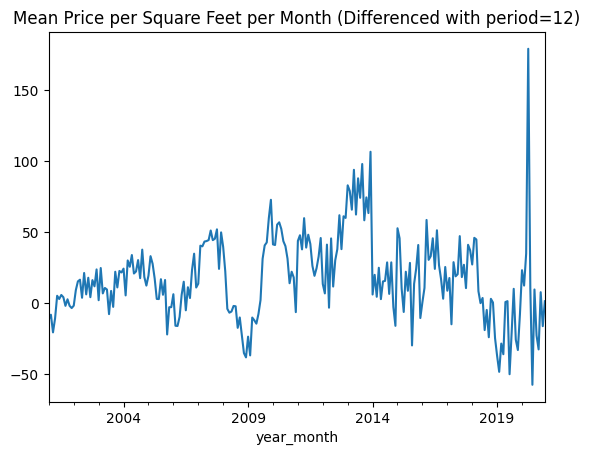

In [30]:
mean_monthly_price_psf_diff.plot(
    kind='line',
    title='Mean Price per Square Feet per Month (Differenced with period=12)',
)

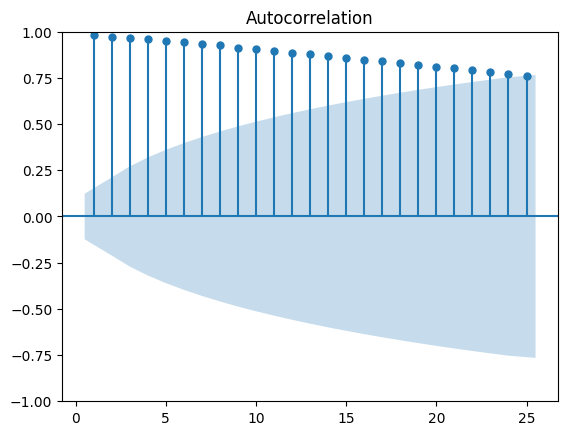

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(mean_monthly_price_psf['price_psf'], zero=False)
plt.show()

Based on the ACF plot, there are statistically significant lag from 1 to 24. This means that the monthly `price_psf` are highly correlated with each other. When the `price_psf` increases, it tends to continue rising; conversely, if it falls, it tends to continue to fall:
1. Might suggest a seasonal pattern with a periodicity of 24 time points (2 years)
2. May indicate that differencing is needed to achieve stationarity
3. Consider decomposing time series into its trend, seasonal, and residual components using methods like seasonal decomposition of time series (STL)
4. Evaluate fitted models using metrics like AIC or BIC

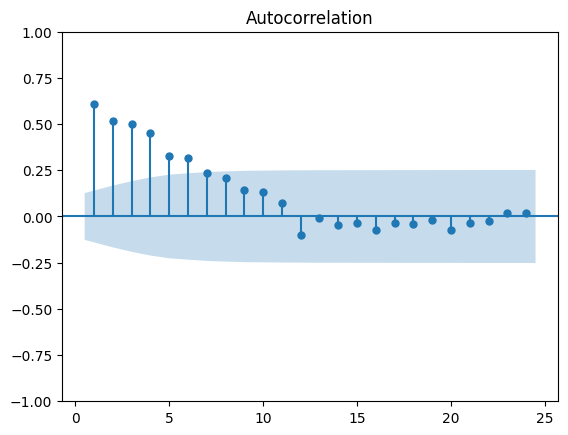

In [32]:
plot_acf(mean_monthly_price_psf_diff, zero=False)
plt.show()

After differencing with period of 12, the ACF plot shows statistically significant coefficient up to lag 6. This means that the monthly `price_psf` are not correlated with each other up to 6 months and we can use `q=6` for ARIMA model.

Let's do the same for PACF.

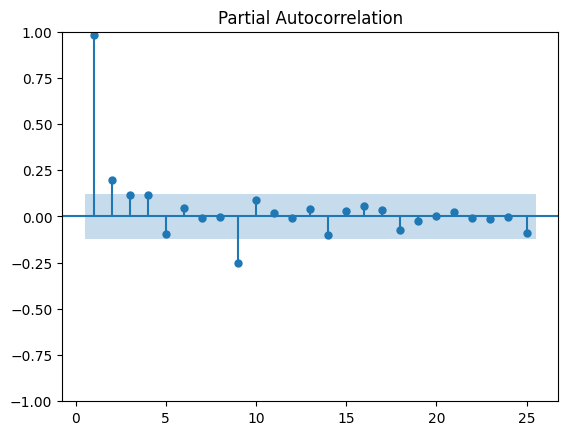

In [33]:
plot_pacf(mean_monthly_price_psf['price_psf'], zero=False)
plt.show()

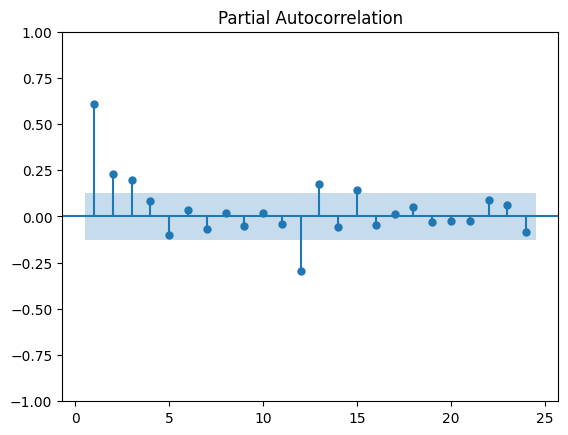

In [34]:
plot_pacf(mean_monthly_price_psf_diff, zero=False)
plt.show()

In the original time series, the PACF plot shows statistically significant coefficient up to lag 2. This means that the monthly `price_psf` are correlated with each other up to 2 months. However, differenced time series shows statistically significant coefficient up to lag 3 .

We can use `p=3`, `q=6` and `i=12` for ARIMA model.

In [35]:
def block_cv(series: pd.Series, n_splits=5, test_sample_size=6, return_list=False):
    n = len(series)
    fold_size = int(n / n_splits)

    start = 0
    end = fold_size
    train_size = 1 - (test_sample_size / fold_size)

    for i in range(n_splits):
        split = series.iloc[start:start + fold_size]

        train = split[:int(fold_size * train_size)]
        test = split[int(fold_size * train_size):]

        if return_list:
            yield train.index.to_list(), test.index.to_list()
        else:
            yield train, test

        start += fold_size
        end += fold_size

In [36]:
def plot_cv_indices(X: pd.DataFrame, n_splits=5, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    _, ax = plt.subplots()

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(block_cv(X, n_splits=n_splits, return_list=True)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        print(f'Split {ii}: {tr}, {tt}')

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits, -0.2],
        title="Block cross validation of monthly price per square feet",
    )

    return ax

Split 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], [42, 43, 44, 45, 46, 47]
Split 1: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [90, 91, 92, 93, 94, 95]
Split 2: [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137], [138, 139, 140, 141, 142, 143]
Split 3: [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185], [186, 187, 188, 189, 190, 191]
Split 4: [192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

<Axes: title={'center': 'Block cross validation of monthly price per square feet'}, xlabel='Sample index', ylabel='CV iteration'>

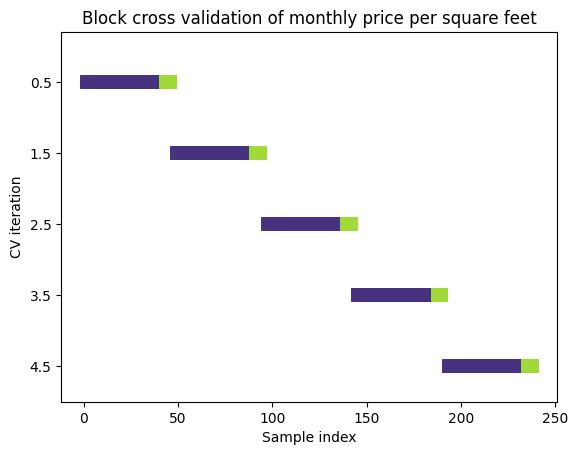

In [37]:
plot_cv_indices(mean_monthly_price_psf_diff.reset_index())

In [38]:
from itertools import product

p = range(1,4)
i = range(1,13)
q = range(1,7)
orders = list(product(p, i, q))
print(f'Number of orders: {len(orders)}')

Number of orders: 216


  0%|          | 0/216 [00:00<?, ?it/s]

100%|██████████| 216/216 [03:40<00:00,  1.02s/it]


<Axes: title={'center': 'RMSE and MAE'}, xlabel='order'>

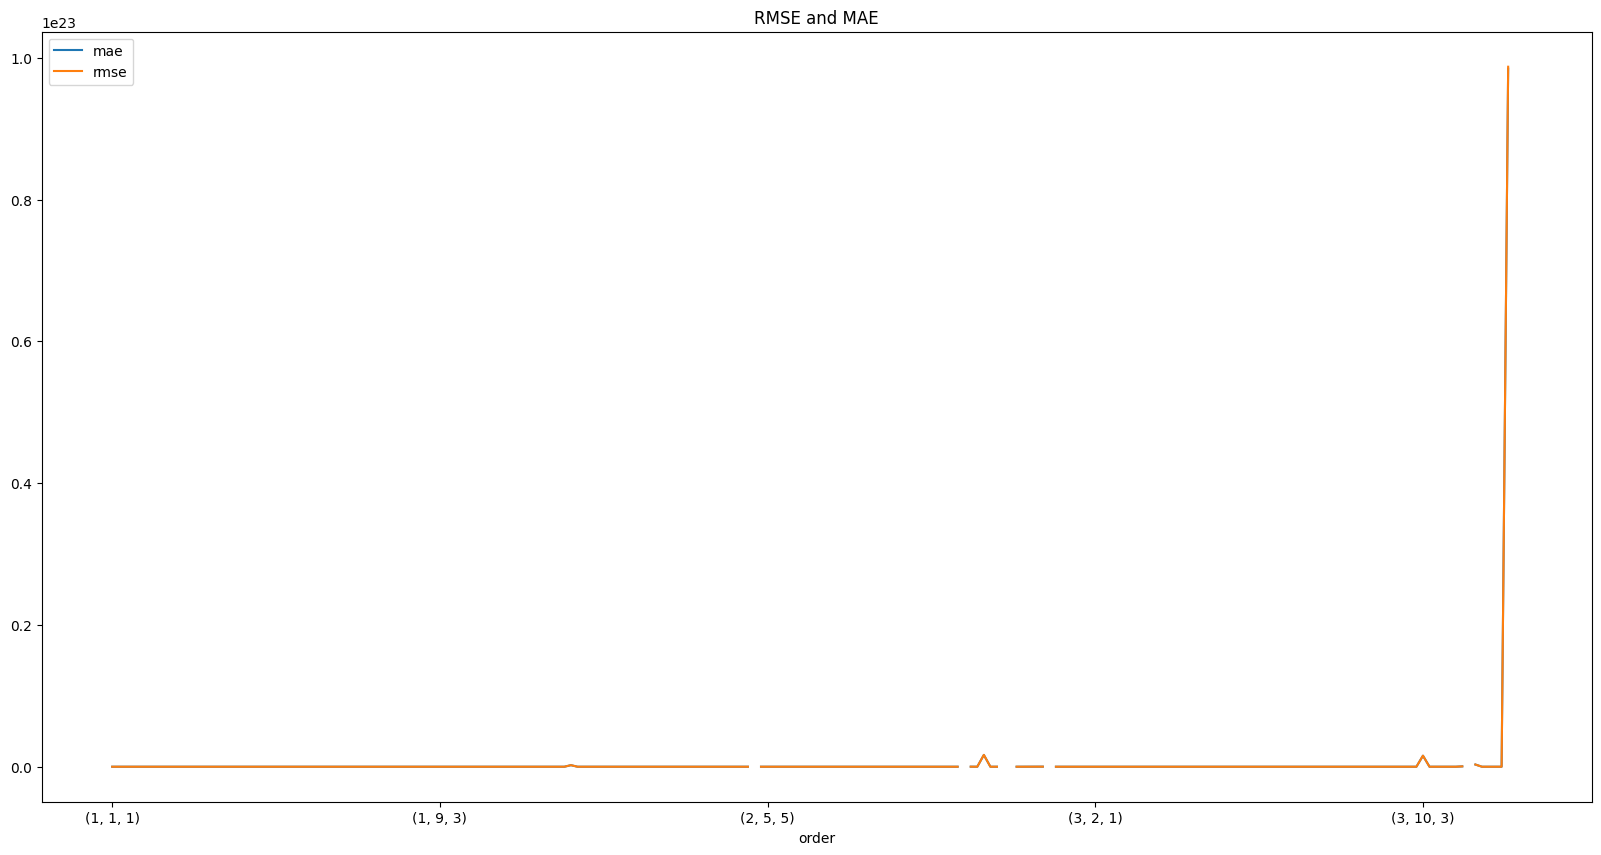

In [39]:
from statsmodels.tsa.arima.model import ARIMA
mae = []
rmse = []
for order in tqdm(orders, total=len(orders)):
    # print(f'order = {order}')
    for fold, (train, test) in enumerate(block_cv(mean_monthly_price_psf['price_psf'], n_splits=1)):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                arima = ARIMA(train, order=order, freq=mean_monthly_price_psf['price_psf'].index.inferred_freq).fit()
                arima_forecast = arima.forecast(len(test))
                mae.append(np.mean(np.abs(arima_forecast - test)))
                rmse.append(np.sqrt(np.mean((arima_forecast - test) ** 2)))
                # print(f'Fold: {fold}, AIC: {arima.aic}, BIC: {arima.bic}')
                # print(f'MAE: {np.mean(np.abs(arima_forecast - test))}')
                # print(f'RMSE: {np.sqrt(np.mean((arima_forecast - test) ** 2))}')
                # print(f'Forecast: \n{arima_forecast}, Actual: \n{test}')
            except:
                mae.append(np.nan)
                rmse.append(np.nan)

df_arima_eval = pd.DataFrame({'order': orders, 'mae': mae, 'rmse': rmse})
df_arima_eval.plot(
    x='order',
    y=['mae', 'rmse'],
    kind='line',
    title='RMSE and MAE',
    figsize=(20, 10)
)

In [40]:
df_arima_eval.query('mae == mae.min()')

,order,mae,rmse
6,"(1, 2, 1)",10.457793,12.944158


In [41]:
df_arima_eval.query('rmse == rmse.min()')

,order,mae,rmse
79,"(2, 2, 2)",11.100091,12.661069


d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


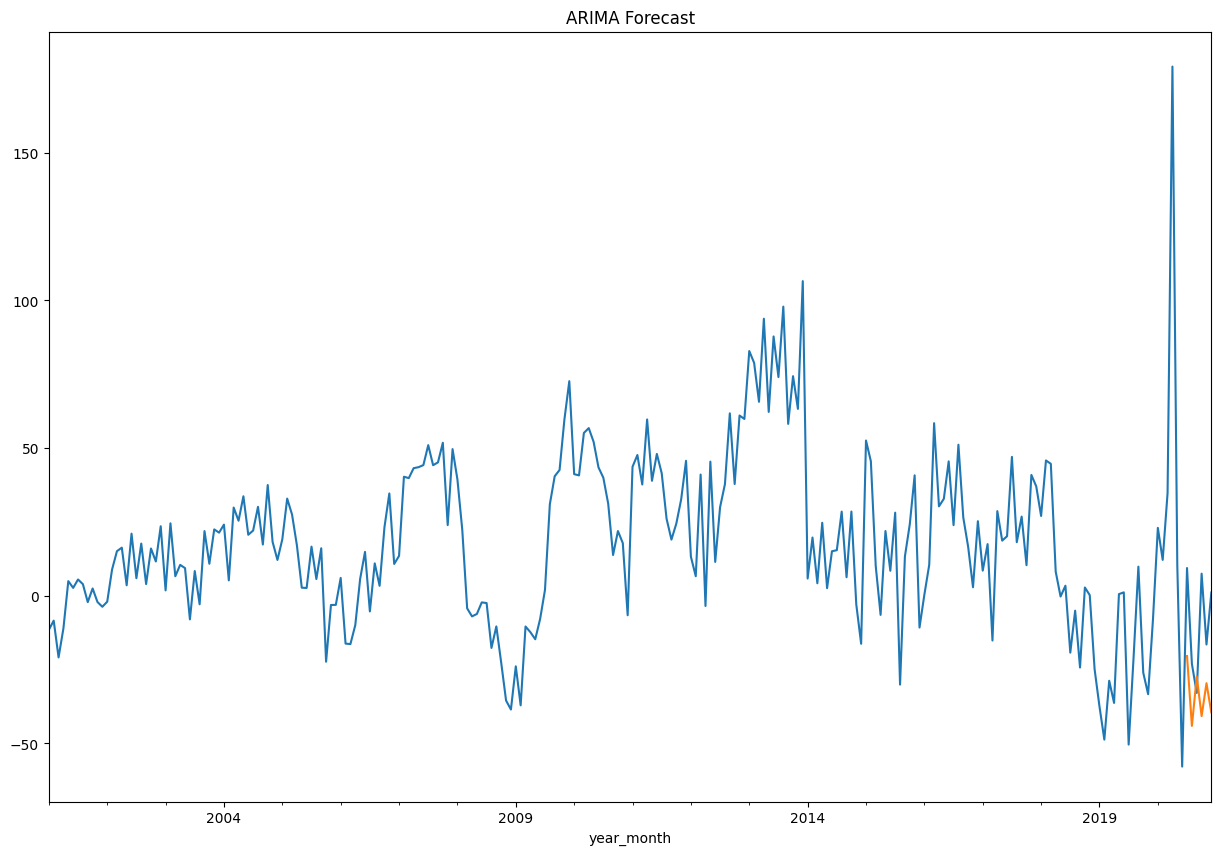

In [42]:
best_order = (2, 2, 2)

train = mean_monthly_price_psf_diff.iloc[:-6]
test = mean_monthly_price_psf_diff.iloc[-6:]

arima = ARIMA(train, order=best_order, freq=mean_monthly_price_psf['price_psf'].index.inferred_freq).fit()
arima_forecast = arima.forecast(6)

mean_monthly_price_psf_diff.plot(
    kind='line',
    title='Mean Price per Square Feet per Month (Differenced with period=12)',
    figsize=(15, 10)
)
arima_forecast.plot(
    kind='line',
    title='ARIMA Forecast',
    figsize=(15, 10)
)
plt.show()

<Axes: title={'center': 'ARIMA Residuals'}, xlabel='year_month'>

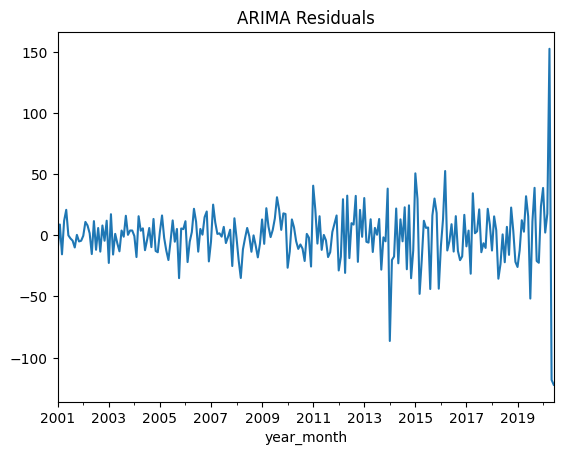

In [43]:
arima.resid.plot(
    kind='line',
    title='ARIMA Residuals'
)

Contrary to the literature, ARIMA performed badly on the data. Let's try SARIMA.

  0%|          | 0/216 [00:00<?, ?it/s]

100%|██████████| 216/216 [03:41<00:00,  1.03s/it]


<Axes: title={'center': 'RMSE and MAE'}, xlabel='order'>

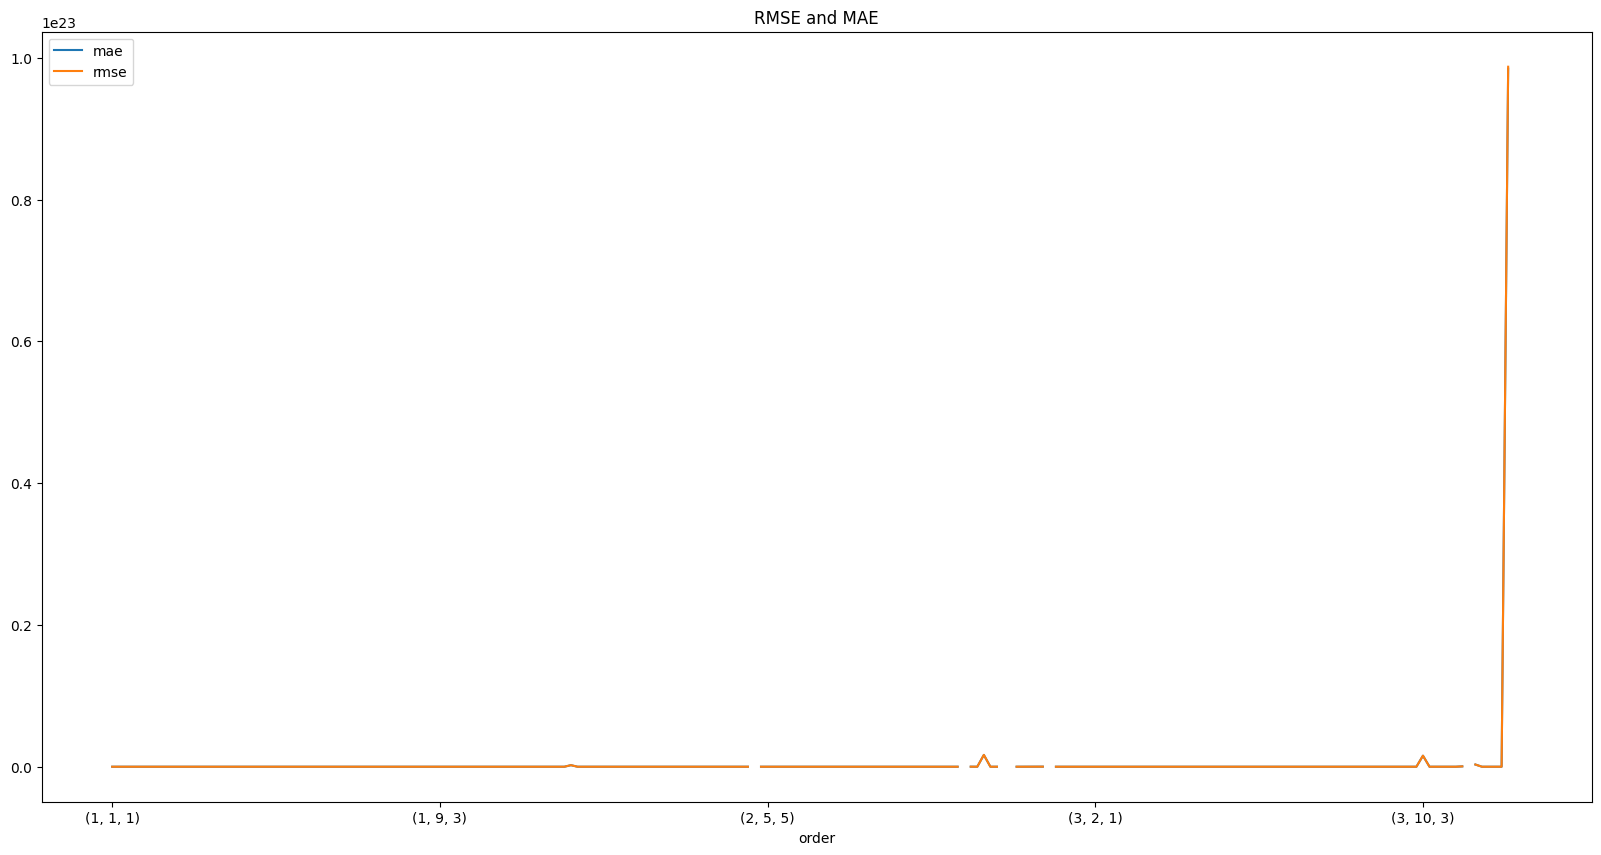

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mae = []
rmse = []
for order in tqdm(orders, total=len(orders)):
    # print(f'order = {order}')
    for fold, (train, test) in enumerate(block_cv(mean_monthly_price_psf['price_psf'], n_splits=1)):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                sarima = SARIMAX(train, order=order, freq=mean_monthly_price_psf['price_psf'].index.inferred_freq).fit()
                sarima_forecast = sarima.forecast(len(test))
                mae.append(np.mean(np.abs(sarima_forecast - test)))
                rmse.append(np.sqrt(np.mean((sarima_forecast - test) ** 2)))
                # print(f'Fold: {fold}, AIC: {arima.aic}, BIC: {arima.bic}')
                # print(f'MAE: {np.mean(np.abs(arima_forecast - test))}')
                # print(f'RMSE: {np.sqrt(np.mean((arima_forecast - test) ** 2))}')
                # print(f'Forecast: \n{arima_forecast}, Actual: \n{test}')
            except:
                mae.append(np.nan)
                rmse.append(np.nan)

df_sarima_eval = pd.DataFrame({'order': orders, 'mae': mae, 'rmse': rmse})
df_sarima_eval.plot(
    x='order',
    y=['mae', 'rmse'],
    kind='line',
    title='RMSE and MAE',
    figsize=(20, 10)
)

In [51]:
df_sarima_eval.query('mae == mae.min()')

,order,mae,rmse
6,"(1, 2, 1)",10.457793,12.944158


In [52]:
df_sarima_eval.query('rmse == rmse.min()')

,order,mae,rmse
79,"(2, 2, 2)",11.100091,12.661069


d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


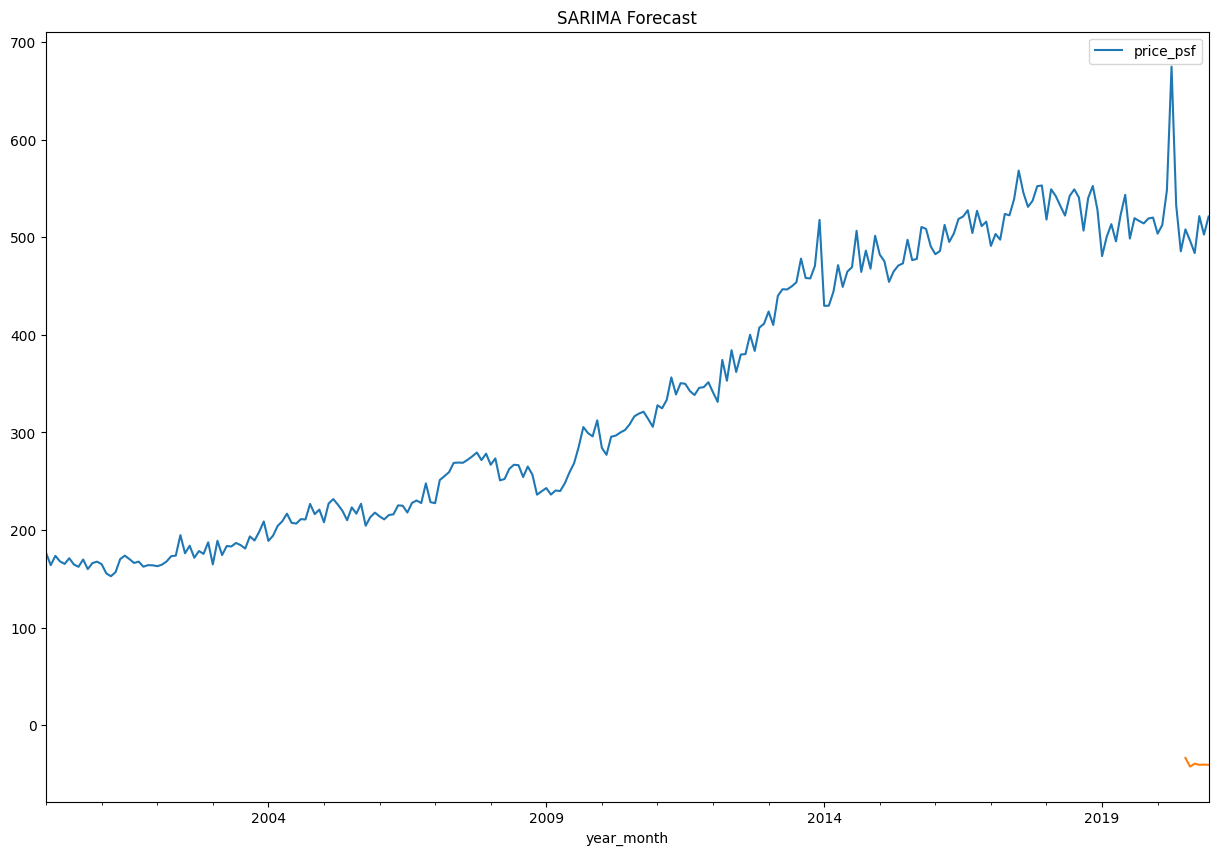

In [69]:
best_order = (1, 2, 1)

train = mean_monthly_price_psf_diff.iloc[:-6]
test = mean_monthly_price_psf_diff.iloc[-6:]

sarima = SARIMAX(train, order=best_order, freq=mean_monthly_price_psf['price_psf'].index.inferred_freq).fit()
sarima_forecast = sarima.forecast(6)

mean_monthly_price_psf.plot(
    kind='line',
    title='Mean Price per Square Feet per Month',
    figsize=(15, 10)
)
sarima_forecast.plot(
    kind='line',
    title='SARIMA Forecast',
    figsize=(15, 10)
)
plt.show()

<Axes: title={'center': 'SARIMA Residuals'}, xlabel='year_month'>

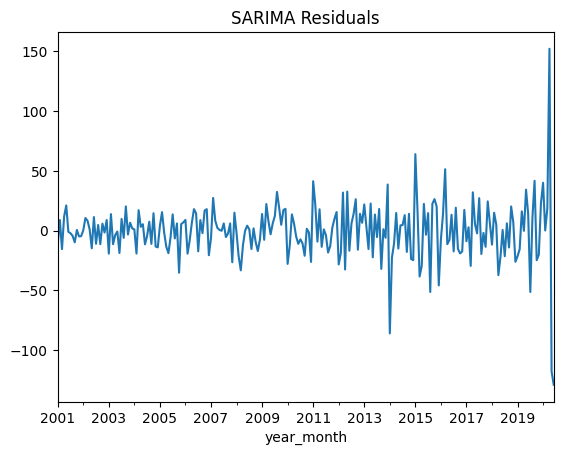

In [54]:
sarima.resid.plot(
    kind='line',
    title='SARIMA Residuals',
)

100%|██████████| 12/12 [00:00<00:00, 65.57it/s]


<Axes: title={'center': 'RMSE and MAE'}, xlabel='periods'>

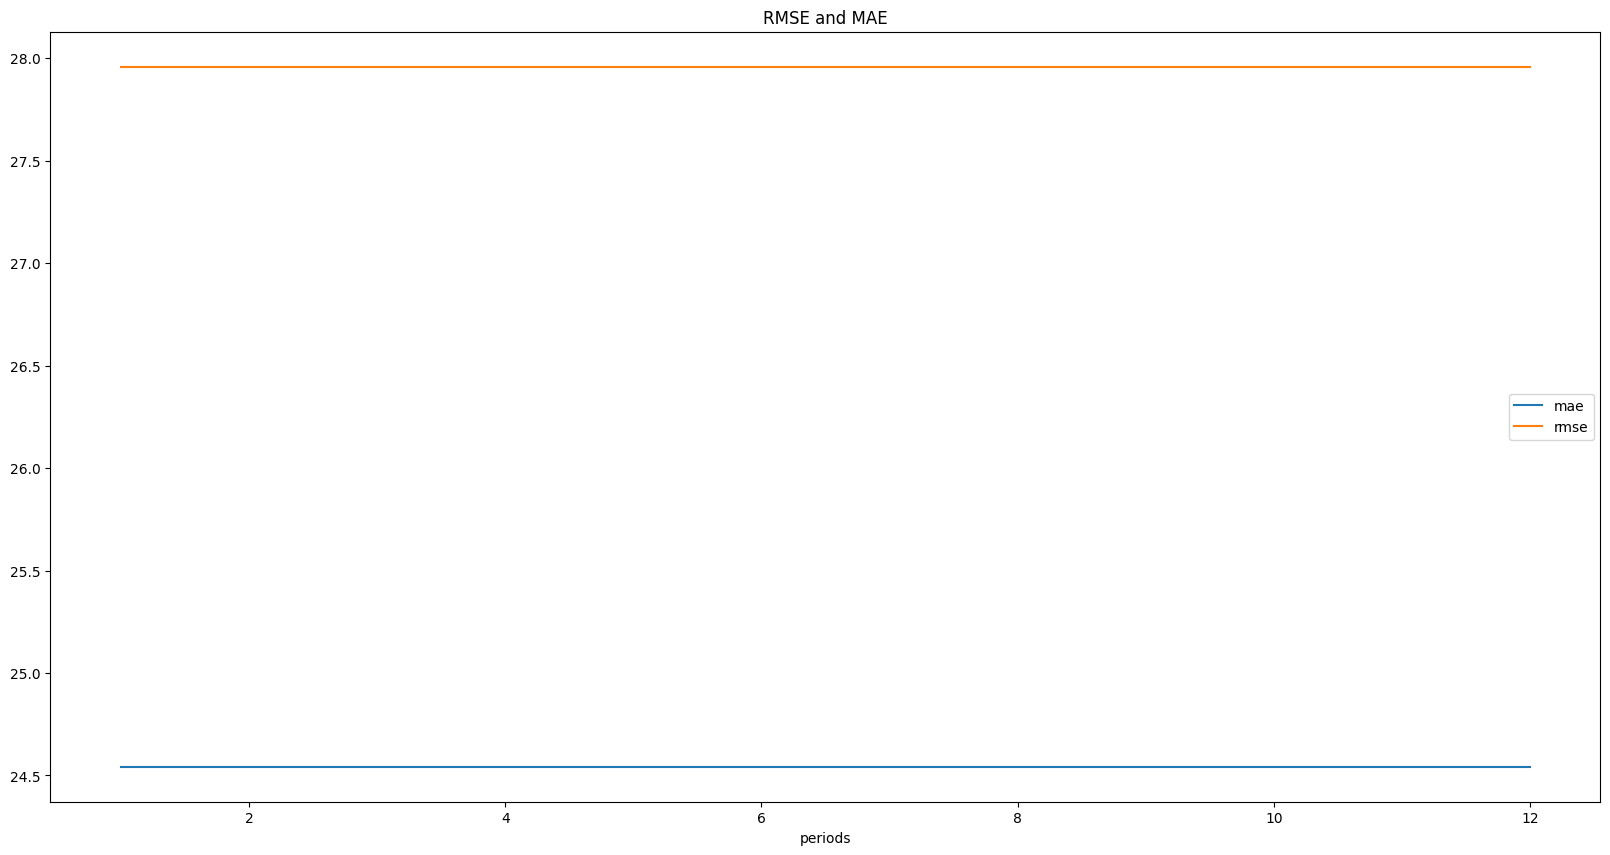

In [60]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
mae = []
rmse = []
periods = range(1,13)
for period in tqdm(periods, total=len(periods)):
    for fold, (train, test) in enumerate(block_cv(mean_monthly_price_psf['price_psf'], n_splits=1)):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                holtwinters = ExponentialSmoothing(train, freq=mean_monthly_price_psf['price_psf'].index.inferred_freq, seasonal_periods=period).fit()
                holtwinters_forecast = holtwinters.forecast(len(test))
                mae.append(np.mean(np.abs(holtwinters_forecast - test)))
                rmse.append(np.sqrt(np.mean((holtwinters_forecast - test) ** 2)))
                # print(f'Fold: {fold}, AIC: {arima.aic}, BIC: {arima.bic}')
                # print(f'MAE: {np.mean(np.abs(arima_forecast - test))}')
                # print(f'RMSE: {np.sqrt(np.mean((arima_forecast - test) ** 2))}')
                # print(f'Forecast: \n{arima_forecast}, Actual: \n{test}')
            except:
                mae.append(np.nan)
                rmse.append(np.nan)

df_holtwinters_eval = pd.DataFrame({'periods': periods, 'mae': mae, 'rmse': rmse})
df_holtwinters_eval.plot(
    x='periods',
    y=['mae', 'rmse'],
    kind='line',
    title='RMSE and MAE',
    figsize=(20, 10)
)

In [61]:
df_holtwinters_eval.query('mae == mae.min()')

,periods,mae,rmse
0,1,24.542424,27.958789
1,2,24.542424,27.958789
2,3,24.542424,27.958789
3,4,24.542424,27.958789
4,5,24.542424,27.958789
5,6,24.542424,27.958789
6,7,24.542424,27.958789
7,8,24.542424,27.958789
8,9,24.542424,27.958789
9,10,24.542424,27.958789


In [62]:
df_holtwinters_eval.query('rmse == rmse.min()')

,periods,mae,rmse
0,1,24.542424,27.958789
1,2,24.542424,27.958789
2,3,24.542424,27.958789
3,4,24.542424,27.958789
4,5,24.542424,27.958789
5,6,24.542424,27.958789
6,7,24.542424,27.958789
7,8,24.542424,27.958789
8,9,24.542424,27.958789
9,10,24.542424,27.958789


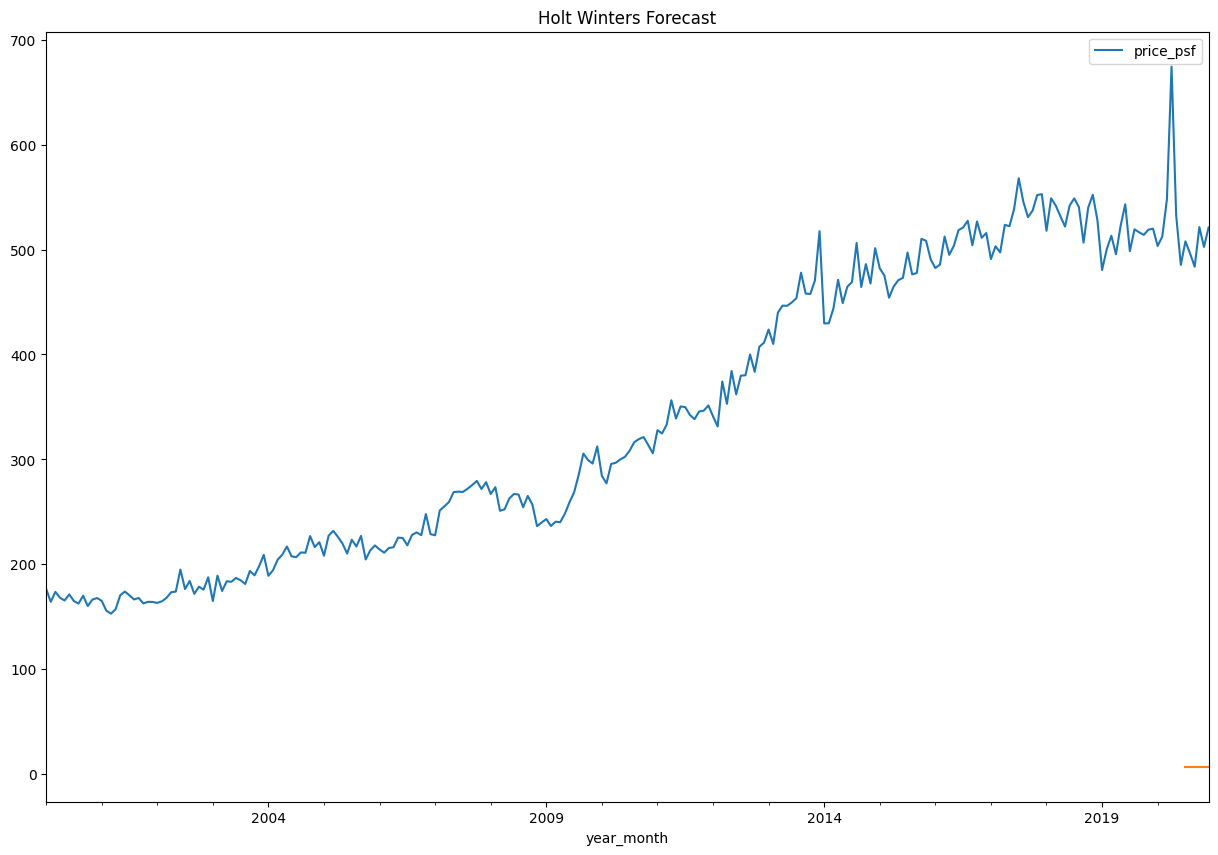

In [67]:
best_period = 12

train = mean_monthly_price_psf_diff.iloc[:-6]
test = mean_monthly_price_psf_diff.iloc[-6:]

holtwinters = ExponentialSmoothing(train,freq=mean_monthly_price_psf['price_psf'].index.inferred_freq, seasonal_periods=best_period,).fit()
holtwinters_forecast = holtwinters.forecast(6)

mean_monthly_price_psf.plot(
    kind='line',
    title='Mean Price per Square Feet per Month (Differenced with period=12)',
    figsize=(15, 10)
)
holtwinters_forecast.plot(
    kind='line',
    title='Holt Winters Forecast',
    figsize=(15, 10)
)
plt.show()